Link to paper: [Zenke, Ganguli - 2018](https://direct.mit.edu/neco/article/30/6/1514-1541/8378)

Zenke's [Tutorial](https://github.com/fzenke/spytorch) on Surrogate Gradient Descent using PyTorch.

To Implement:
1. LIF Neurons (maybe a class of such neurons)
2. Fast Sigmoid Function

Question:
1. How to implement spiking neural network in pytorch? 
  * use RNNs as Zenke suggests in his tutorial?

In [ ]:
#@title Dependencies
import numpy as np
from matplotlib import pyplot as plt


# import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [122]:
dtype = torch.float
device = torch.device("cpu")

# Uncomment the line below to run on GPU
device = torch.device("cuda:0") 

### Network Architecture (Zenke)

3 layer feed-forward neural network

In [ ]:
nb_inputs  = 100
nb_hidden  = 4
nb_outputs = 2

In [ ]:
batch_size = 256

### Spiking Neuron Model Setup (Zenke)

Since we are technically stimulating an RNN, the neurons have to be simulated for a certain number of timesteps

In [ ]:
time_step = 1e-3
nb_steps  = 200

In [ ]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

Initializing weights from a normal distribution, the variance is scaled with the inverse square root of the number of input connections.

Dale's Law is ignored here.

In [ ]:
#@title Weight Matrcies
weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

print("init done")

In [ ]:
#@title The Spiking Non-linearity
def spike_fn(x):
  out = torch.zeros_like(x)
  out[x > 0] = 1.0
  return out

In [ ]:
h1 = torch.einsum("abc,cd->abd", (x_data, w1))

Initialize the synaptic currents and the membrane potentials at zero. Then implement a loop that stimulates the neuron models over time, and record the membrane potential and output spikes of all trials and all neurons.

In [ ]:
# tensors initialized with zeros for synaptic current and membrane potential
syn = torch.zeros((batch_size, nb_hidden), device=device, dtype=dtype)
mem = torch.zeros((batch_size, nb_hidden), device=device, dtype=dtype)

# two lists to record the membrane potentials and output spikes
mem_rec = []
spk_rec = []

# The simulation loop
for t in range(nb_steps):
  m_thr = mem - 1.0
  out = spike_fn(m_thr)
  rst = out.detach() # we do not want to backprop through the reset

  new_syn = alpha*syn + h1[:, t]
  new_mem = (beta*mem + syn)(1 - rst)

  mem_rec.append(mem)
  spk_rec.append(out)

  mem = new_mem
  syn = new_syn

mem_rec = torch.stack(mem_rec, dim=1)
spk_rec = torch.stack(spk_rec, dim=1)




In [ ]:
def run_snn(inputs):

  h1 = torch.einsum('abc,cd->abd', (inputs,w1))
  syn = torch.zeros((batch_size, nb_hidden), device=device, dtype=dtype)
  mem = torch.zeros((batch_size, nb_hidden), device=device, dtype=dtype)
  # lists to record the membrane potentials and the synaptic currents:
  mem_rec = []
  spk_rec = []
  # loop to simulate time
  for t in range(nb_steps):
    mthr = mem - 1.0
    out = spike_fn(mthr)
    rst = out.detach()  # do not want to backpropagate through reset

    new_syn = alpha*syn + h1[:, t]
    new_mem = (beta*mem + syn)(1 - rst)

    mem_rec.append(mem)
    spk_rec.append(out)

    mem = new_mem
    syn = new_syn
  
  # create tensors to stack the elements in the recording lists
  mem_rec = torch.stack(mem_rec, dim=1)
  spk_rec = torch.stack(spk_rec, dim=1)

  # readout layer
  h2 = torch.einsum('abc,cd->abd', (spk_rec, w2))
  flt = torch.zeros((batch_size, nb_outputs), device=device, dtype=dtype)
  out = torch.zeros((batch_size, nb_outputs), device=device, dtype=dtype)
  out_rec = [out]
  for t in range(nb_steps):
    new_flt = alpha*flt + h2[:, t]
    new_out = beta*out + flt

    flt = new_flt
    out = new_out

    out_rec.append(out)

  out_rec = torch.stack(out_rec, dim=1)
  other_recs = [mem_rec, spk_rec]
  return out_rec, other_recs


## SuperSpike Implementation

In [ ]:
class SuperSpike(nn.Module):
  def.__init__(self):
    super(SuperSpike, self).__init__()
    self.layers = nn.Sequential()

  def forward(self, x):
    i



In [ ]:
#@title Surrogate Gradient

class SurrGradSpike(torch.autograd.Function):

  scale = 100.0 # controls the steepness of the gradient

  @staticmethod
  def forward(ctx, input):
    '''
    computes a step-function on the input. ctx is a context variable
    that stores information needed later for backpropagation
    '''
    ctx.save_for_backward(input)
    out = torch.zeros_like(input)
    out[input > 0] = 1
    return out

  @staticmethod
  def backward(ctx, grad_output):
    '''
    In the backward method, we recieve a tensor we need to compute 
    the surrogradient of the loss with respect to the input. 
    Here we use the negative half of the fast sigmoid as in 
    Zenke & Ganguli 2018.
    
    '''
    input, _ = ctx.saved_tensors
    grad_input = grad_output.clone()
    grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
    return grad

# overwrite the spike function with the surrograte gradient function
# using the apply method
spike_fn = SurrGradSpike.apply


#### Loss Function

The van rossum distance is evaluated as:
$$ L = (\alpha*S_i - \alpha*\hat{S_i})^2 $$

where $ \alpha $ is a double exponential filter. 

### Double Exponential Filter




In [4]:

def doubleExponential(spike_train, dt, t_rise, t_decay, time):
  """
  Implements the double exponential kernel
  input:
    spike_train - time series of spikes containing ones and zeros
    dt
    t_rise - time constant of first exponential filter
    t_decay - time constant of second exponential filter
    time - tuple with start & stop time (wrt spike_train) for the convolution
  Returns:
    the convolved double exponential product
  """
  time_range = time[1] - time[0]

  z = torch.zeros(time_range)
  z_hat = torch.zeros(time_range)

  for t in range(time_range):
    z[t+1] =  z[t] + (-z[t]/t_rise + spike_train[t])*dt
    z_hat[t+1] = z_hat[t] + (-z_hat[t] + z[t])*dt/t_decay

  return z_hat

### Hebbian Coincidence Detection & Synaptic Eligibility Trace

$$ \frac{dw_{ij}}{dt} = r\int_{-\infty}^t ds\ e_i(s)\ \alpha * [\sigma'(U_i(s))(\epsilon*S_j(s))]  $$

The evalutation of this equation requires:
1. evaluation of presynaptic traces
2. evaluation of hebbian coincidence and computation of the synaptic eligibility traces
3. compuatation and propagation of error signals
4. integration of this equation and weight update



Here $ \lambda_{ij} = \sigma'(U_i(s))(\epsilon*S_j(s)) $ is the eligibility trace.

Fast sigmoid: $$   \sigma(x) = \frac{x}{1 + |x|} $$

So, $ \sigma'(U_i) = \frac{1}{(1 + |h_i|)^2} $

where $ h_i = \beta(U_i - \nu) $


In [28]:
def presynaptic_trace(value_exp1, value_exp2, spike, args):
  """
  Input:
    value_exp1 - 1-D array containing values of the single
                 exponential trace at the previous timestep shape: (n, 1)
    value_exp2 - 1-D array containing values of the second 
                 exponential trace at the previous timestep, shape: (n,1)
    spike - 1-D array containing 0s or 1s for n presynaptic neurons
    args['t_rise'] - 
    args['t_decay'] -
  Returns:
    the value of the presynaptic trace at the current timestep
  """
  dt = args['timestep_size']
  t_rise = args['t_rise']
  t_decay = args['t_decay']

  #print("Presynaptic Traces value_exp1, shape", value_exp1.shape)
  #print("Presynaptic Traces value_exp2, shape", value_exp2.shape)
  
  z = value_exp1 + (-value_exp1/t_rise + spike)*dt
  z_hat = value_exp2 + (-value_exp2 + value_exp1)*dt/t_decay
  
  return z, z_hat

In [7]:
def eligibility_trace(mem, spike_train, args):
  """
  input:
    mem: membrane potential of i-th neuron for all 
         relevant timesteps, 1-D array shape: (timesteps)
    spike_train: j-th neuron, 1-D array, shape: (timesteps)
    thres: firing threshold
  Returns:
    eligibility trace
  """
  thres = args['thres']
  t_rise = args['t_rise']
  t_decay = args['t_decay']
  
  beta = 1 # mV^-1
  h_i = beta*(mem - thres)

  post = 1 / (1 + torch.abs(h_i))**2 
  pre_synaptic_trace = doubleExponential(spike_train, dt, t_rise, t_decay, time)

  hebbian = post * pre_synaptic_trace #hebbian coincidence term

  #synaptic eligibility trace
  eligibility_trace = doubleExponential(hebbian, dt, t_rise, t_decay, time)

  return elibility_trace

### Error Signal

In [8]:
#@title Output Error Signal

def error_signal(spike_train, desired_spike_train):
  """
  Returns the error signal (time series)
  """
  # output spike train
  filter_1 = doubleExponential(spike_train, dt, t_rise,
                               t_decay, time)
  # desired spike train
  filter_2 = doubleExponential(desired_spike_train, dt, t_rise,
                               t_decay, time)
  
  error = filter_2 - filter_1
  return error


In [9]:
def error_signal2(value_exp1, value_exp2, output, target, args):
  """

  """

  t_rise = args['t_rise_alpha']
  t_decay = args['t_decay_alpha']
  dt = args['timestep_size']

  difference = target - output

  z = value_exp1 + (-value_exp1/t_rise + difference)*dt
  z_hat = value_exp2 + (-value_exp2 + value_exp1)*dt/t_decay


  return z, z_hat


In [ ]:
#@title Feedback Signal

def feedback_signal():
  """
  
  Returns:

  """


  return feedback

### Per Parameter Learning Rate

Zenke & Ganguli (2018) used a per parameter learning rate. **bold text**

In [ ]:
def learning_rate():
  """

  """

### Regularization Term

Heterosynaptic regularization term to the learning rule of the hidden layers to avoid pathologically high firing rates.



In [ ]:
def regularization_term():
  

### Poisson Spike Trains

Based on the method suggested by David Heeger [here](https://www.cns.nyu.edu/~david/handouts/poisson.pdf)



In [10]:
def Poisson_trains(n, lam, timesteps, dt):
  """

  inputs:
    n - number of poisson spike trains 
    lam - 1-D array containing mean value of poisson trains
  Returns

  """
  trains = torch.zeros((n, timesteps), device=device, dtype=dtype)
  unif = torch.rand((n, timesteps), device=device, dtype=dtype)

#  counter = 0
  for i in range(n):
    trains[unif <= lam[i]*dt] = 1
#    counter += len(unif <= lam[i]*dt)
#  print("Total No. of Spikes", counter)

  return trains

In [11]:
trains = Poisson_trains(1, 1000*np.ones(10), 1000, 1e-4)

#print(trains)

In [12]:
#@title Step Function for Spikes
def spike_fn(x, thres):
  """
  Implements a heaviside function centred at the firing threshold
  """
  x = x - thres
  out = torch.zeros_like(x)
  out[x > 0] = 1
  return out

In [58]:
def van_rossum_loss(output, target, args):

  z = 0
  z_hat = 0
  t_rise = args['t_rise_alpha']
  t_decay = args['t_decay_alpha']
  dt = args['timestep_size']

  loss = 0

  #output = output.flatten(start_dim=1)

  #print("Output Spike Train Shape:", output.shape)
  #print("Target Spike Train Shape:", target.shape)

  for i in range(len(output)):

    difference = target[i] - output[i]
  #  print(difference.shape)
    z = z + (-z/t_rise + difference)*dt
    z_hat = z_hat + (-z_hat + z)*dt/t_decay
    
    loss += dt*z_hat**2 

  return (1/2)*loss



In [29]:
def eligibility_trace2(value_exp1, value_exp2, hebbian, args):
  """
  i: no. of presynaptic neurons
  j: no. of postsynaptic neurons
  Input:
    value_exp1 - 2-D array containing values of the single exponential
                 trace at the previous timestep. Shape: (i, j)
    value_exp2 - 2-D array containing values of the second exponential
                 trace at the previous timestep Shape: (i, j)
    hebbian - 2-D array
    args['t_rise_alpha']
    args['t_decay_alpha']
  Returns:

  """
  dt = args['timestep_size']
  t_rise = args['t_rise_alpha']
  t_decay = args['t_decay_alpha']

#  print("last eligibility Value_exp1 shape:", value_exp1.shape)
#  print("last eligibility Value_exp2 shape:", value_exp2.shape)
#  print("hebbian shape", hebbian.shape)

  z = value_exp1 + (-value_exp1/t_rise + hebbian)*dt
  z_hat = value_exp2 + (-value_exp2 + value_exp1)*dt/t_decay

  return z, z_hat

### Single Neuron Model

Property | Value|
-----| -----|
threshold | -50 mV
U_rest | -60 mV
tau_mem| 10 ms
tau_syn| 5 ms
tau_ref| 5 ms



In [14]:
nb_inputs = 100 # 100 spike trains as inputs that repeat every 500 ms
nb_outputs = 1 

batch_size = 256

nb_steps = 5000
timestep_size = 1e-4 # 0.1 msec timesteps


In [2]:
# LIF Neuron Model Parameters
args = {'thres': 1,
        'U_rest': -60,
        'tau_mem': 1e-2,
        'tau_syn': 5e-3,
        'tau_ref': 5e-3,
        't_rise': 5e-3, # the pre-synaptic double exponential kernel rise time
        't_decay': 1e-2, # the pre-synaptic double exponential kernel decay time
        'timestep_size': 1e-4,
        't_rise_alpha': 5e-3,
        't_decay_alpha': 1e-2} 

In [3]:
tau_syn = args['tau_syn']
tau_mem = args['tau_mem']

alpha = float(torch.exp(-timestep_size/tau_syn))
beta = float(torch.exp(-timestep_size/tau_mem))
print(type(beta))

NameError: ignored

In [17]:
def weight_update(input, output, target, mem, args):
  update = torch.zeros(nb_outputs)

  for i in range(nb_outputs):
    update[i] = error_signal(output, target)*eligibility_trace(mem, input[i]
  update = error_signal(output, target)*


SyntaxError: ignored

In [18]:
#@title Input Spike Trains

spk_freq = 10 # not sure about this, but assuming it since the paper
# uses 10 Hz frequency as the target output frequency (actually 
# 5 equidistant spikes over 500 ms)

input_trains = Poisson_trains(100, spk_freq*np.ones(100),
                              nb_steps, timestep_size)

In [19]:
#@title Target Spike Train
## 5 equidistant spikes spread over 0.5 secs
target = torch.zeros(nb_steps)
target[:: nb_steps//5] = 1

In [113]:
#@title Weight Initialization

weight_scale = 7*(1 - beta) # copied from spytorch

weights = torch.empty((nb_inputs), device=device, dtype=dtype)
torch.nn.init.normal_(weights, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))
print("Weight initialization done")

Weight initialization done


In [125]:
mem = torch.zeros(nb_outputs, device=device, dtype=dtype)
syn = torch.zeros(nb_outputs, device=device, dtype=dtype)

epochs = 10
thres = args['thres']

loss_rec = []
for i in tqdm(range(epochs)):

  m = 0
  mem_rec = []
  spk_rec = []

  eligibility_trace_record = torch.zeros((nb_inputs, nb_steps), device=device, dtype=dtype)
 # pre_trace_rec = torch.zeros((nb_inputs, nb_inputs, nb_steps), device=device, dtype=dtype)
  

  eligibility_rec = []
  pre_trace_rec = []

  out_spks = torch.zeros(nb_steps, device=device, dtype=dtype)
  
  last_presynaptic_traces = [torch.zeros(nb_inputs, device=device, dtype=dtype),
                             torch.zeros(nb_inputs, device=device, dtype=dtype)],
  last_eligibility_traces = [torch.zeros(nb_inputs, device=device, dtype=dtype),
                             torch.zeros(nb_inputs, device=device, dtype=dtype)] # not sure about the shape here, might have to recheck

  last_error_values = [torch.zeros(nb_inputs, device=device, dtype=dtype),
                            torch.zeros(nb_inputs, device=device, dtype=dtype)]
  for t in range(nb_steps):

    weighted_inp = input_trains[:, t] * weights

    out = spike_fn(mem, thres)
    reset = out

    spk_rec.append(out)
    mem_rec.append(mem)

    new_syn = alpha*syn + weighted_inp
    new_mem = (beta*mem + syn*(1 - beta))*(1 - reset)

    mem = new_mem
    # compute presynaptic traces
    presynaptic_traces = presynaptic_trace(last_presynaptic_traces[0],
                                           last_presynaptic_traces[1],
                                           input_trains[:, t], args)
    
    last_presynaptic_traces = presynaptic_traces
    ##pre_trace_rec.append(presynaptic_traces)

    # evaluate hebbian coincidence and synaptic eligibility traces
    h = mem - thres
    post = 1 / (1 + torch.abs(h))**2

  

    hebbian = post * presynaptic_traces[1]

    synaptic_eligibility = eligibility_trace2(last_eligibility_traces[0],
                                     last_eligibility_traces[1],
                                     hebbian, args)

    last_eligibility_traces = synaptic_eligibility

  
    error = error_signal2(last_error_values[0], last_error_values[1],
                          out, target[t], args)
    
    last_error_values = error
    # for minibatching weight updates in time
  #  print("Error shape:", error[1].shape)
  #  print("Eligibility Shape:", synaptic_eligibility[1].shape)

    m += error[1] * synaptic_eligibility[1]
  
  #  print("\n")
  print(m.shape)
  weights += m
  spk_rec = torch.stack(spk_rec, dim=0)
  loss = van_rossum_loss(spk_rec, target, args)
  print("Loss =", loss)
  loss_rec.append(loss)


  spk_rec = torch.flatten(spk_rec)
  print(spk_rec)

  plot_single_train(spk_rec, nb_steps, timestep_size)
  plt.show()

print(loss_rec)


plt.plot(loss_rec)
    

    
  

    

    


  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: ignored

#### Raster Plot

In [102]:
def plot_single_train(spike_train, nb_steps, timestep_size, idx=0):

  positions = np.arange(0, nb_steps*timestep_size, timestep_size)
  spike_positions = positions[spike_train == 1]
 # print(spike_positions)
  plt.eventplot(spike_positions, lineoffsets=idx)
  #plt.show()

def plot_trains(spike_trains, title='Spike Trains'):
  plt.figure(dpi = 100)
  for i in range(len(spike_trains)):
    plot_single_train(spike_trains[i], nb_steps, timestep_size, idx=i)
  plt.title(title)
  plt.xlabel('Time (in sec)')
  plt.ylabel('Spike Train No.')
  plt.show()

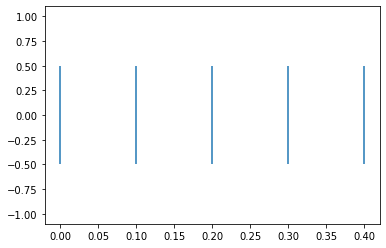

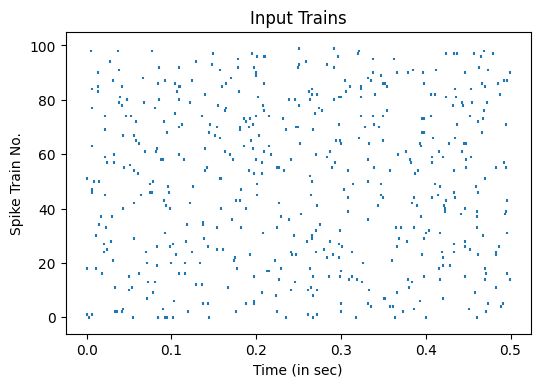

In [103]:
plot_single_train(target, nb_steps, timestep_size)
plt.show()

plot_trains(input_trains, title = "Input Trains")